We want to examine linear spreading speeds, in this case, on the line graph, for small $p = O(\epsilon)$. This is largely a modification of the Bakhshi survey.

In [1]:
# Importin my needed libraries
import numpy as np 
from matplotlib import pyplot as plt
import networkx as nx
import DynaNet
import Equations
%matplotlib notebook

from numpy import linalg

from importlib import reload
reload(DynaNet)
reload(Equations)

<module 'Equations' from 'C:\\Users\\wrmag\\Documents\\School\\Spring 23\\RAShip\\DynamicNetwork\\Equations.py'>

<IPython.core.display.Javascript object>


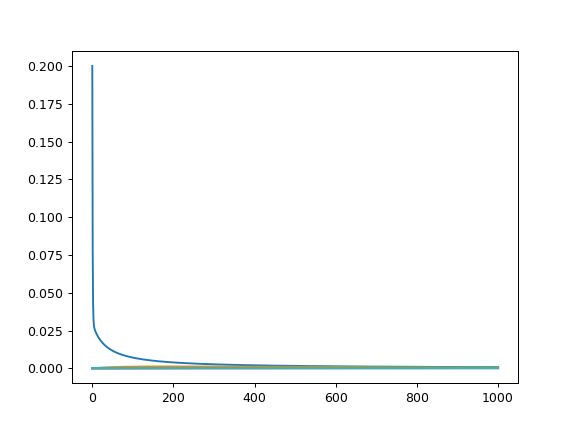

The solver successfully reached the end of the integration interval.
True


In [2]:
# Set graph parameters
graph_size = 100

# Line graphs
ident = np.identity(graph_size)
adj = np.roll(ident, 1) + np.roll(ident, -1) 
adj[0, 0] = 0
adj[graph_size-1, graph_size-1] = 0
online, offline = adj, adj
#print(adj)

# Create a multiplexed dynamic graph model
MG = DynaNet.MultiplexDynaNet([online, offline])
MG.generate_incidence()
MG.generate_laplacian()
MG.generate_multi_laplacian()

# Set up our multiplexed Fisher-KPP equation
MDE = Equations.MultiplexRxnDffn

# Set up equation parameters
ks = np.array([-0.001 for ii in range(graph_size)] + [-0.002 for ii in range(graph_size)])
vs = np.zeros(2*graph_size)
epsilon = 0.1

def coupling(state):
    p = 0
    omega = 1
    alpha, theta = 1, 1
    gamma = 2
    beta = 20
    u = state[:graph_size]
    v = state[graph_size:]
    u_next = omega*(-u + gamma*u*(1-u)/(1+np.exp(-beta*(v-alpha))))
    v_next = 1-v*theta*(1+u)**p
    return np.concatenate((u_next, v_next))

# Set up initial conditions
t0 = 0.0
tf = 1000.0
nt = 1000
A, k, B = 0.2, 10, .7
u0 = A*np.exp(-k*np.arange(graph_size))
v0 = B*np.ones(graph_size)
f0 = np.concatenate((u0, v0))

# Run simulation
MG.solve_ivp(MDE, f0, t0, tf, nt, ks, vs, coupling)
res = MG.solve_ivp_results

for ii in range(graph_size):
    plt.plot(res.t, res.y[ii, :], label=f'{ii}')
    #plt.legend()

#print(res.t)
#print(np.linspace(t0, tf, nt))
print(res.message)
print(res.success)

To get a better idea of what exactly is going on with the strangely osccilating noise, let's explode the view.

<IPython.core.display.Javascript object>


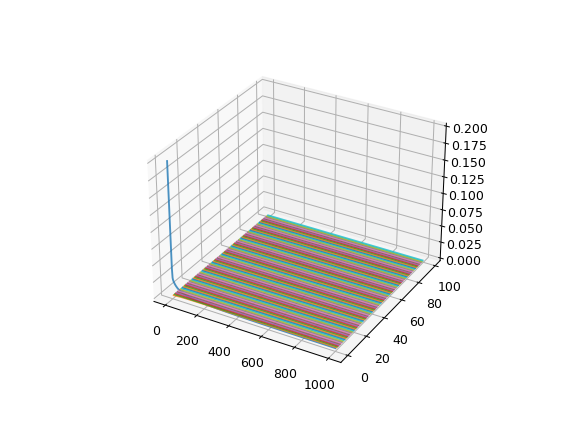

In [4]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
y_ticks = list(range(graph_size))
for ii in y_ticks:    
    ax.plot(res.t, res.y[ii, :], zs=ii, zdir='y', alpha=0.8)

<IPython.core.display.Javascript object>


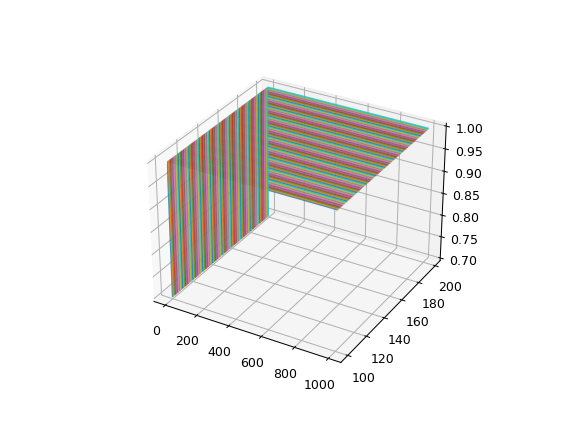

In [5]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
y_ticks = list(range(graph_size, 2 * graph_size))
for ii in y_ticks:    
    ax.plot(res.t, res.y[ii, :], zs=ii, zdir='y', alpha=0.8)

Lets focus on the $u$ field, or the social tension. For small $p$, the social unrest, $v$ is nearly decoupled from $u$. Recall, that for $p=0$, if $\frac{\Gamma}{2}-\omega < 0$, then our linear spreading speed can not be defined, but we may still be able to define a selected spreading speed through thresholding.

In [6]:
def get_numeric_spreading_speed(time_results, spatial_results, thresh):
    # Take only u values from the combined vector
    u_vec = spatial_results[:graph_size, :]
    
    # Determine at which times the u is above the threshold value
    u_thresh = u_vec > thresh
    
    # Get first arriaval index from each column. Distances already in order
    first_indicies = np.argmax(u_thresh, axis=1)
    
    # Get corresponding first time
    first_times = time_results[first_indicies]
    
    return first_times
    

<IPython.core.display.Javascript object>


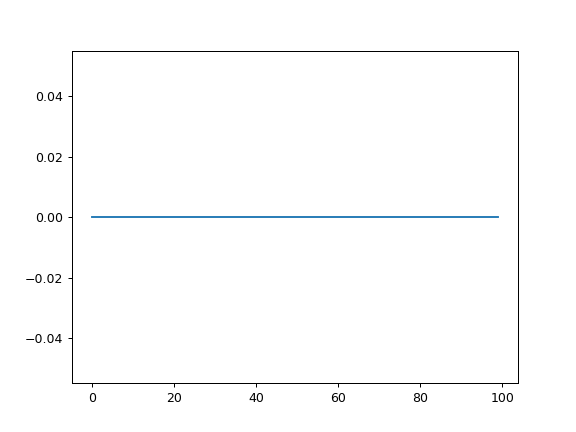

In [7]:
first_times = get_numeric_spreading_speed(res.t, res.y, 0.21)
plt.plot(first_times)

## Comparison to Theory

Lets begin by looking at what Theory might suggest. Consider the unperturbed case where $p=0$ and $v$ is decoupled from $u$. Allowing $v$ to exhibit fast diffusion and equillibrate to $v^* = \mathbf{1}$, we can observe $u$ to simply follow

$$
\dot{\mathbf{u}} =  d_1 \nabla_{G}^2 \mathbf{u} + r(\mathbf{1})\mathbf{u}(\mathbf{1}-\mathbf{u})-\omega \mathbf{u} = d_1 \nabla_{G}^2 \mathbf{u} + \frac{\Gamma}{2}\mathbf{u}(\mathbf{1}-\mathbf{u})-\omega \mathbf{u}
$$

If we consider an infinite line graph, $G$, and selecting an arbitrary starting point, labeling it $u_0$, the set of equations are simply 

$$
\dot{u_j} = d_1(u_{j+1} + u_{j-1} - 2u_{j}) + \frac{\Gamma}{2}u_j(1-u_j) - \omega u_j
$$

Using the standard ansatz, $u_j = e^{\lambda t - \gamma j}$, our equation reads

$$
\lambda = d_1(e^{-\gamma} + e^{\gamma} - 2) \frac{\Gamma}{2}(1-e^{\lambda t - \gamma n}) - \omega
$$

Linearizing about $\mathbf{0}$ (which should be reasonable for the exponential decay ansatz) gives

$$
\lambda = d_1(e^{-\gamma} + e^{\gamma} - 2) + \frac{\Gamma}{2} - \omega 
$$

Boosting into a reference frame, $s\gamma$ gives

$$
d_{s_l}(0, \gamma_l) = 0 = d_1(-2+e^{\gamma_l} + e^{\gamma_l}) + \frac{\Gamma}{2} -\omega - s_l \gamma_l \\
\partial_{\gamma}d_{s_l}(0, \gamma_l) = 0 = d_1(e^{\gamma_l}-e^{-\gamma_l}) - s_l
$$

The roots can be found via rootsolve

In [9]:
from scipy.optimize import root

# set up functions for rootsolving

# Function to rootfind, may take in additions paramters
def pinched_double_root_find(x, d1, Gamma, omega):
    """
    x: (s, \gamma) pair
    d1: diffusion coeff
    Gamma: big gamma from Bakhshi
    omega: damping from Bakhshi
    """
    
    # unpack
    s, gamma = x[0], x[1]
    
    # solve for the root (root) and pinched root (root_der) conditions
    root = -d1 * (-2 + np.exp(-gamma) + np.exp(gamma)) + Gamma / 2 - omega - s * gamma
    root_der = -d1 * (-np.exp(-gamma) + np.exp(gamma)) - s
    
    return (root, root_der)

# compare with simulated parameters
omega = 100
Gamma = 100000
d1 = 0.001

# initial guess will just be what we estimated from the simulation
s0 = 460
g0 = np.arcsinh(2*s0/d1)

# solve the root
sol = root(pinched_double_root_find, np.array([s0, g0]), args=(d1, Gamma, omega))
s_true, g_true = sol.x
print(s_true, g_true)

3873.3049687114762 12.710742657272771


Based on these values, we would need our graph size to be significantly large to see the spreading speed converge to $3543.85\ldots$, so it may be worth examining the spreading speeds for smaller values of $\gamma$ to try to get everything to converge faster.

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0 2.0


C:\Users\wrmag\anaconda3\envs\DynaEnv\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in double_scalars


[ 11.01101101  24.02402402  35.03503504  46.04604605  57.05705706
  67.06706707  77.07707708  87.08708709  97.0970971  107.10710711
 117.11711712 127.12712713 137.13713714 147.14714715 157.15715716
 167.16716717 177.17717718 187.18718719 196.1961962  206.20620621
 216.21621622 226.22622623 236.23623624 246.24624625 256.25625626
 265.26526527 275.27527528 285.28528529 295.2952953  305.30530531
 314.31431431 324.32432432 334.33433433 344.34434434 354.35435435
 364.36436436 373.37337337 383.38338338 393.39339339 403.4034034
 412.41241241 422.42242242 432.43243243 442.44244244 452.45245245
 461.46146146 471.47147147 481.48148148 491.49149149 500.5005005
 510.51051051 520.52052052 530.53053053 540.54054054 549.54954955
 559.55955956 569.56956957 579.57957958 588.58858859 598.5985986
 608.60860861 618.61861862 627.62762763 637.63763764 647.64764765
 657.65765766 667.66766767 676.67667668 686.68668669 696.6966967
 706.70670671 715.71571572 725.72572573 735.73573574 745.74574575
 754.75475475 

<IPython.core.display.Javascript object>


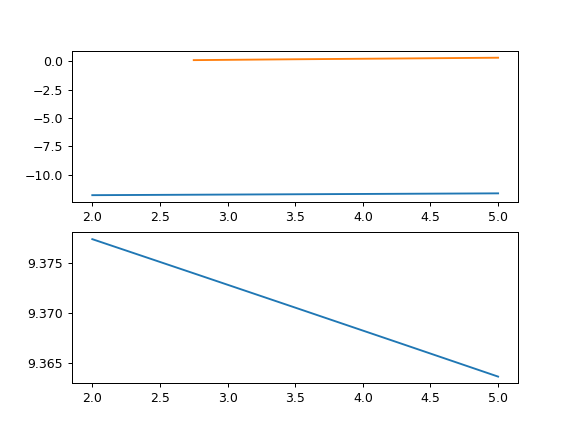

In [10]:
# Parameter sweep on Gamma from 1e0 to 1e5
partitions = 5
Gammas = np.linspace(2, 5, partitions)

ss = np.zeros(partitions)
s_sim = np.zeros(partitions)
gammas = np.zeros(partitions)
gamma_sim = np.zeros(partitions) 

for iG, Gamma in enumerate(Gammas):
    # solve the root
    sol = root(pinched_double_root_find, np.array([0.1, 0.1]), args=(d1, Gamma, omega))
    s_true, g_true = sol.x
    ss[iG] = s_true
    gammas[iG] = g_true
    
    # now simulate
    
    def coupling(state):
        p = 0
        omega = 1
        alpha, theta = 1, 1
        gamma = Gamma/omega
        beta = 20
        u = state[:graph_size]
        v = state[graph_size:]
        u_next = omega*(-u + gamma*u*(1-u)/(1+np.exp(-beta*(v-alpha))))
        v_next = 1-v*theta*(1+u)**p
        return np.concatenate((u_next, v_next))

    # Run simulation
    MG.solve_ivp(MDE, f0, t0, tf, nt, ks, vs, coupling)
    results = MG.solve_ivp_results

    first_times = get_numeric_spreading_speed(results.t, results.y, 0.21)
    print(first_times)
    print(iG, Gamma)
    
    # estimate spreading speed
    s_sim[iG] = 1/np.polyfit(np.arange(80, 100), first_times[80:], 1)[0]
    
fig, axes = plt.subplots(2)
axes[0].plot(Gammas, ss)
axes[0].plot(Gammas, s_sim)
axes[1].plot(Gammas, gammas)

In [52]:
Gammas

array([  1000.        ,   3162.27766017,  10000.        ,  31622.77660168,
       100000.        ])

In [60]:
np.linspace(0, 10, 4)[-1]

10.0

- Keep with teh weak p dependence
- Will the pulse, if smaller, propogate under
- Do a parameter Survey for smaller $\Gamma$

In [26]:
tf

100.0

In [101]:
first_times = get_numeric_spreading_speed(res.t, res.y, 0.5)

In [102]:
first_times

array([0.18418418, 0.22222222, 0.26626627, 0.3023023 , 0.33233233,
       0.35835836, 0.38238238, 0.4024024 , 0.42242242, 0.44044044,
       0.45645646, 0.47247247, 0.48848849, 0.5025025 , 0.51451451,
       0.52652653, 0.53853854, 0.55055055, 0.56256256, 0.57257257,
       0.58258258, 0.59259259, 0.6026026 , 0.61261261, 0.62062062,
       0.63063063, 0.63863864, 0.64664665, 0.65465465, 0.66266266,
       0.67067067, 0.67867868, 0.68468468, 0.69269269, 0.6986987 ,
       0.70670671, 0.71271271, 0.71871872, 0.72672673, 0.73273273,
       0.73873874, 0.74474474, 0.75075075, 0.75675676, 0.76276276,
       0.76876877, 0.77477477, 0.77877878, 0.78478478, 0.79079079,
       0.7967968 , 0.8008008 , 0.80680681, 0.81081081, 0.81681682,
       0.82082082, 0.82682683, 0.83083083, 0.83683684, 0.84084084,
       0.84484484, 0.85085085, 0.85485485, 0.85885886, 0.86286286,
       0.86886887, 0.87287287, 0.87687688, 0.88088088, 0.88488488,
       0.88888889, 0.89489489, 0.8988989 , 0.9029029 , 0.90690

In [58]:
s_sim

array([747.28346457, 747.28346457, 747.28346457, 747.28346457,
       747.28346457])

In [55]:
a = [0.002002 ,  0.01201201 ,0.02202202 ,0.03003003, 0.03603604, 0.04404404,
 0.05005005 ,0.05605606, 0.06206206, 0.06806807 ,0.07207207 ,0.07807808,
 0.08208208 ,0.08608609, 0.09009009, 0.09409409 ,0.0980981  ,0.1021021,
 0.10610611 ,0.11011011, 0.11411411, 0.11611612, 0.12012012, 0.12412412,
 0.12612613 ,0.13013013, 0.13213213, 0.13613614, 0.13813814, 0.14014014,
 0.14414414 ,0.14614615, 0.14814815, 0.15215215, 0.15415415, 0.15615616,
 0.15815816 ,0.16016016, 0.16416416, 0.16616617, 0.16816817, 0.17017017,
 0.17217217 ,0.17417417, 0.17617618, 0.17817818, 0.18018018, 0.18218218,
 0.18418418 ,0.18618619, 0.18818819, 0.19019019, 0.19219219, 0.19419419,
 0.19419419 ,0.1961962 , 0.1981982 , 0.2002002 , 0.2022022 , 0.2042042,
 0.20620621 ,0.20620621, 0.20820821, 0.21021021, 0.21221221, 0.21221221,
 0.21421421 ,0.21621622, 0.21821822, 0.22022022, 0.22022022, 0.22222222,
 0.22422422 ,0.22422422, 0.22622623, 0.22822823, 0.22822823, 0.23023023,
 0.23223223 ,0.23423423, 0.23423423, 0.23623624, 0.23823824, 0.23823824,
 0.24024024 ,0.24224224, 0.24224224, 0.24424424, 0.24624625, 0.24624625,
 0.24824825 ,0.25025025, 0.25025025, 0.25225225, 0.25425425, 0.25425425,
 0.25625626 ,0.25825826, 0.25825826, 0.26026026]

In [57]:
1/np.polyfit(np.arange(80, 100), a[80:], 1)[0]

747.2834602757218

In [109]:
Gammas

array([   1000.        ,    5623.4132519 ,   31622.77660168,
        177827.94100389, 1000000.        ])